<a href="https://colab.research.google.com/github/xAleksandraKitlas/grafika-projrkt1/blob/main/lab8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Najpierw wykonujemy instalacje środowiska


In [ ]:
!nvcc --version
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-8ddy0b34
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-8ddy0b34
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=54ae401f1e9baf9ae5edbffa67adbcb842def5f134d4e30e3480c58f33c70d69
  Stored in directory: /tmp/pip-ephem-wheel-cache-y6wy5u16/wheels/f3/08/cc/e2b5b0e1c92df07dbb50a6f024a68ce090f5e7b2316b41756d
Successfully built NVCCPlugin
cr

Nastepnie wykonuje sie kod algorytmu tworzacego fractal Mandelbrota, a takze zapisujemy do pliku punkty


**CPU**

In [ ]:
%%cu
#include <stdio.h>
#include <time.h>
#include <unistd.h>

#define WIDTH 500
#define HEIGHT 500

// Struktura przechowująca dane piksela
struct Pixel {
  unsigned char r;
  unsigned char g;
  unsigned char b;
};

// Wyliczanie wartości fraktala Mandelbrota dla punktu
void mandelbrot(Pixel *pixels, int width, int height) {
  for (int y = 0; y < height; y++) {
    for (int x = 0; x < width; x++) {
      float real = (x - width/2.0f) * 4.0f/width;
      float imag = (y - height/2.0f) * 4.0f/width;

      float c_real = real;
      float c_imag = imag;

      int value = 0;
      int iterations = 0;

      while (iterations < 255 && value < 4) {
        float r2 = real*real;
        float i2 = imag*imag;

        imag = 2*real*imag + c_imag;
        real = r2 - i2 + c_real;

        value = r2 + i2;
        iterations++;
      }

      // Ustawianie koloru piksela na podstawie liczby iteracji
      Pixel p;
      p.r = iterations;
      p.g = iterations;
      p.b = iterations;
      pixels[y*width + x] = p;
    }
  }
}

int main() {
  clock_t start_time = clock();
  // Alokowanie pamięci na obraz
  Pixel *pixels = (Pixel*)malloc(WIDTH*HEIGHT*sizeof(Pixel));

  // Wywołaj funkcję mandelbrot
  mandelbrot(pixels, WIDTH, HEIGHT);

 // Zapisz wynik do pliku
 FILE *f = fopen("fractal.txt", "w");
 for (int y = 0; y < HEIGHT; y++) {
   for (int x = 0; x < WIDTH; x++) {
     Pixel p = pixels[y*WIDTH + x];
     fprintf(f, "%d %d %d\n", p.r, p.g, p.b);
   }
 }
fclose(f);

// Zwalnianie pamięci
free(pixels);
clock_t end_time = clock();
double elapsed_time = (double)(end_time - start_time) / CLOCKS_PER_SEC;
printf("Czas wykonywania programu: %f sekund\n", elapsed_time);

int result = access("data.csv", F_OK);
if(result==-1){
// Zapisz dane do pliku
  FILE *k = fopen("data.csv", "w");
  fprintf(k, "Czas trwania programu [s],Wartość\n");
  fprintf(k, "%.2f,%.d\n", elapsed_time, WIDTH);
  fclose(k);}
else{
  FILE *k = fopen("data.csv", "a");
  fprintf(k, "%.2f,%.d\n", elapsed_time, WIDTH);
  fclose(k);}

return 0;
}

Czas wykonywania programu: 0.107110 sekund



Tutaj odczytujemy punkty i rysujemy fractal

In [ ]:
from PIL import Image

# Otwieranie pliku tekstowego i wczytywanie danych pikseli
with open("fractal.txt") as f:
    pixels = [tuple(map(int, line.split())) for line in f]

# Rysowanie obrazu i ustawianie kolory pikseli
width = 1500
height = 1500
image = Image.new("RGB", (width, height))
image.putdata(pixels)

# Zapisywanie obraz
image.save("fractal.png")

**GPU**

In [ ]:
%%cu
#include<stdio.h>
#define DIM 2000

//struktura liczby zespolonej
//zmienna r to część rzeczywista
//zmienna i to część urojona
//dla CUDA, tutaj __device__ oznaczającego, że dany fragment kodu 
//ma zostać wykonany na GPU. Należy pamiętać, że funkcje
//zadeklarowane jako __device__ można wywoływać tylko z innych 
//funkcji tego samego typu lub typu __global__
struct cuComplex{
  float r;
  float i;
  __device__ cuComplex(float a, float b):r(a),i(b){}
  __device__ float magnitude2(void){ return r*r+i*i; }
  __device__ cuComplex operator*(const cuComplex &a){
       return cuComplex(r*a.r-i*a.i,i*a.r+r*a.i); }
  __device__ cuComplex operator+(const cuComplex &a){
       return cuComplex(r+a.r,i+a.i); }
};

//funkcja mandelbrot oblicza poszczególne wartości dla poszczególnych pixeli
__device__  int mandelbrot(int x, int y){
  const float scale=1.5;
  float jx=scale*(float)(DIM/2-x)/(DIM/2);
  float jy=scale*(float)(DIM/2-y)/(DIM/2);
  cuComplex c(jx,jy);
  cuComplex a(0,0);
  int i=0;
  for(i=0;i<200;i++){
    a=a*a+c;
    if(a.magnitude2()>1000) return 0; 
  }
  return 1;
}

//pusta funkcje o nazwie kernel() z kwalifikatorem __global__ - informuje on
//kompilator o tym, że dana funkcja powinna zostać skompilowana dla
//urządzenia a nie hosta
__global__ void kernel(unsigned char *ptr){
  int x=blockIdx.x;
  int y=blockIdx.y;
  int offset=x+y*gridDim.x;
  int mandelbrotValue=mandelbrot(x,y);
  ptr[offset*4+0]=255*mandelbrotValue;
  ptr[offset*4+1]=0;
  ptr[offset*4+2]=0;
  ptr[offset*4+3]=255;
}

struct DataBlock{
  unsigned char *dev_bitmap;
};

//metoda wypisująca wartości RGB dla każdego poszczególnego pixela
void wypisz_RGB_fraktal(unsigned char *ptr){
  for(int y=0;y<DIM;y++){
    for(int x=0;x<DIM;x++){
      int offset=x+y*DIM;
      printf("\n%d, %d, %d, %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2], ptr[offset*4+3]);
    }
  }
}

//funkcja która zapisuje wartości rgb do pliku .ppm
// struktura pliku:
//#'P3 
//# R G B'
void save_to_file(unsigned char *ptr){
  FILE *fp=fopen("Fraktal_M_GPU.ppm","w");
  fprintf(fp,"P3\n%d %d\n255\n", DIM, DIM);
  for(int y=0;y<DIM;y++){
    for(int x=0;x<DIM;x++){
      int offset=x+y*DIM;
      fprintf(fp,"\n%d %d %d", ptr[offset*4+1], ptr[offset*4+0],ptr[offset*4+2]);
    }
  }
  fclose(fp);
}                                                                                                                                                                                                              

//funkcja główna
//Uruchamiany tu jest zegar, liczy on czas wykonania zadania
//funkcja cudaMalloc() rezerwuje w pamięci GPU miejsce na przekazany argument.
//zmienna dim3 odpowiada za definiowanie wątków jako zmienną dwu wymiarową.
//kernel<<<x,y>>>() wywołuje funkcję kernel.
//cudaMemcpy() kopiuje parametr z pamięci host do pamięci device.
//cudaFree() zwalnia pamięć
int main(void){
  clock_t start, end;
  double execution_time;
  start = clock();

  DataBlock data;
  unsigned char *bitmap = (unsigned char*)malloc(DIM*DIM*4*sizeof(unsigned char));
  int image_size = DIM*DIM*4;
  unsigned char *dev_bitmap;
  cudaMalloc((void**)&dev_bitmap, image_size);
  data.dev_bitmap=dev_bitmap;
  dim3 grid(DIM,DIM);
  kernel<<<grid,1>>>(dev_bitmap);
  cudaMemcpy(bitmap,dev_bitmap,image_size,cudaMemcpyDeviceToHost);
  cudaFree(dev_bitmap);
  save_to_file (bitmap);

  end = clock();
  execution_time = ((double)(end - start))/CLOCKS_PER_SEC;
  printf("Wykonanie zadania zajeło: %f sekund\n", execution_time);
}

Wykonanie zadania zajeło: 1.209792 sekund



Zmieniałam wymiary ręcznie w obu wypadkach: <br>
DIM 100 <br>
Czas wykonania programu na CPU: 0.004776 sekund <br>
Czas wykonania programu na GPU: 0.677428 sekund <br>
DIM 500 <br>
Czas wykonania programu na CPU: 0.106799 sekund <br>
Czas wykonania programu na GPU: 0.728245 sekund <br>
DIM 1000<br>
Czas wykonania programu na CPU: 0.440805 sekund <br>
Czas wykonania programu na GPU: 0.775621 sekund <br>
DIM 1500<br>
Czas wykonania programu na CPU: 0.983370 sekund <br>
Czas wykonania programu na GPU: 0.551098 sekund <br>
DIM 2000<br>
Czas wykonania programu na CPU: 1.709582 sekund <br>
Czas wykonania programu na GPU: 1.286943 sekund <br>

WYKRES

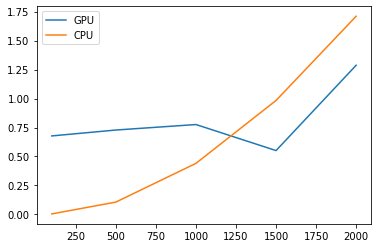

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# tablice z czasami CPU, GPU i badanymi DIM
timeCPU = [0.004776, 0.106799, 0.440805, 0.983370, 1.709582]
timeGPU = [0.677428, 0.728245, 0.775621, 0.551098, 1.286943]
DIM = [100, 500, 1000, 1500, 2000]
# tutaj rysujemy wykresy za pomoca matplotlib
plt.plot(DIM, timeGPU, label = "GPU")
plt.plot(DIM, timeCPU, label = "CPU")
plt.legend()
plt.show()